In [1]:
pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import scipy.sparse as sp
import scipy as sc
import matplotlib.pyplot as plt
import imageio
import scienceplots

import numba
from numba import jit
from numba import njit
import time
import cupy as cp
import cProfile

plt.style.use(['science', 'notebook', 'grid'])

In [3]:
def Thomas_method(A, f):
    '''
    method solves the linear system with tridiagonal matrix of coefficients
    by using special approach of Gaussian elimination.
    Input: A - np.array() of size n-by-n - matrix of the linear system
           f - np.array() of size n-by-1 - vector of rhs
    Output: x - np.array() of size n-by-1 - solution of the system
    '''
    n = np.shape(A)[0]
    L = np.diag(np.ones(n,dtype=complex))
    U = np.zeros((n,n),dtype=complex)
    y = np.zeros(n,dtype=complex)
    x = np.zeros(n,dtype=complex)
    
    U[0,0] = A[0,0]
    U[0,1] = A[0,1]
    y[0] = f[0]
    
    for i in range(1,n):
        beta_i = A[i,i-1]/U[i-1,i-1]
        alpha_i = A[i,i] - beta_i*A[i-1,i]
        L[i,i-1] = beta_i
        U[i,i] = alpha_i
        U[i-1,i] = A[i-1,i]
        y[i] = f[i]-beta_i*y[i-1]
    
    x[n-1] = y[n-1]/U[n-1,n-1]
    
    for i in range(n-2,-1,-1):
        x[i] = (y[i]-A[i,i+1]*x[i+1])/U[i,i]
    
    return x

In [4]:
def get_Hamiltonian(dt, dx, x, m=1, hdot=1, potential = 'none'):
    '''
    returns H - Hamiltonian for lhs and H_rhs - Hamiltonian for rhs parts of Crank-Nicolson method
    '''
    
    dj = 1+1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj = -1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H
    diagonal = np.ones(len(x), dtype=complex)*dj
    off_diagonal = np.ones(len(x)-1,dtype = complex)*oj
    
    H = sp.diags((off_diagonal,diagonal,off_diagonal),[-1,0,1]).toarray()
    
    dj_rhs = 1-1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj_rhs = 1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H_rhs
    diagonal_rhs = np.ones(len(x), dtype=complex)*dj
    #diagonal_rhs = (np.ones(len(x), dtype=complex)).dot(dj)
    off_diagonal_rhs = np.ones(len(x)-1,dtype = complex)*oj

    H_rhs = sp.diags((off_diagonal_rhs,diagonal_rhs,off_diagonal_rhs),[-1,0,1]).toarray()
    
    if potential == 'none':
        return H, H_rhs
    
    if potential == 'QHO':
        V, V_rhs = QHO(dt,x)
        
        H += V
        H_rhs += V_rhs
        
        return H, H_rhs
    
    if potential == 'DWP':
        V, V_rhs = DWP(x)
        
        H += V
        H_rhs += V_rhs
        
        return H, H_rhs

In [5]:
def QHO(dt,x, m=1, w=1):
    '''
    potential of quantum harmonic oscillator
    '''
    
    v_diagonal = np.ones(len(x),dtype=complex)
    V = np.diag(v_diagonal)

    for ind, xi in enumerate(x):
        V[ind,ind] = 1j*dt*m*w**2*x[ind]**2/4
    
    v_diagonal_rhs = np.ones(len(x),dtype=complex)
    V_rhs = np.diag(v_diagonal)

    for ind, xi in enumerate(x):
        V_rhs[ind,ind] = -1j*dt*m*w**2*x[ind]**2/4 
        
    return V, V_rhs

In [6]:
def DWP(x,x0=2,a=1):
    '''
    double well potential
    '''
    
    v_diagonal = np.ones(len(x),dtype=complex)
    V = np.diag(v_diagonal)

    for ind, xi in enumerate(x):
        V[ind,ind] = 1j*dt*a/x0**4*(x[ind]**2-x0**2)**2/2
    
    v_diagonal_rhs = np.ones(len(x),dtype=complex)
    V_rhs = np.diag(v_diagonal)

    for ind, xi in enumerate(x):
        V_rhs[ind,ind] = -1j*dt*a/x0**4*(x[ind]**2-x0**2)**2/2
        
    return V, V_rhs

In [7]:
def gaus(x,sigma=1,mu=0,p0=0,h=1):
    '''
    initial conditions at t=0 as Gaussian wave packet
    '''
    psi = 1/(np.pi**(1/4)*np.sqrt(sigma))*np.exp(-(x-mu)**2/(2*sigma**2))*np.exp(1j*p0*x/h)
    return psi

In [8]:
def psi_true(y,x,t,w=1,sigma=1,mu=0,p0=0,h=1):
    psi = np.exp(-1j*w*t/2)/np.sqrt(np.pi*(1-np.exp(-1j*2*w*t)))*np.exp(1j*((x**2+y**2)*np.cos(w*t)-2*x*y)/(2*np.sin(w*t)))*1/(np.pi**(1/4)*np.sqrt(sigma))*np.exp(-(x-mu)**2/(2*sigma**2))*np.exp(1j*p0*x/h)
    return psi

In [ ]:
hdot = 1
w = 1
m = 1
dt = 0.5
dx = 0.1
x = np.arange(-10,10,dx)

In [ ]:
H,H_rhs = get_Hamiltonian(dt,dx,x,potential="none")

In [ ]:
initial_cond = gaus(x,sigma=1)

In [ ]:
b = np.dot(H_rhs,initial_cond)

In [ ]:
res = np.zeros((100,len(x)),dtype = complex)
res[0,:] = Thomas_method(H,b)

for i in range(1,100-1):
    res[i,:] = Thomas_method(H,res[i-1,:])

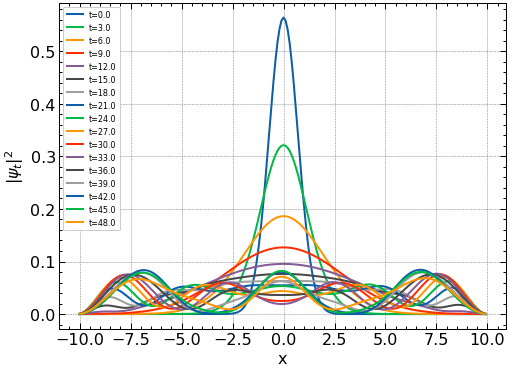

In [ ]:
for i in range(0,100,6):
    plt.plot(x,np.abs(res[i,:])**2, label=f't={dt*i}')
plt.legend(loc=2, prop={'size': 8})
plt.xlabel('x')
plt.ylabel('$|\psi_t|^2$');
plt.savefig(f'pic_no_potential')

In [ ]:
def pic(M,name,i):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x,np.abs(M)**2, label=f't={dt*i}')
    ax.legend(loc=2, prop={'size': 15})
    ax.set_xlabel('x')
    ax.set_ylabel('$|\psi_t|^2$')
    #plt.axis('off')
    fig.savefig(name)
    plt.close(fig);

In [ ]:
plt.ioff()
files = list()
t_values = range(0,100,6)
for i in t_values:
    M = res[i,:]
    pic(M,f'{i+99}animation.png', i)
    files.append(f'{i+99}animation.png')

In [ ]:
images = list()
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'shr1D_no_potential.gif', images, fps = 6);

In [ ]:
H,H_rhs = get_Hamiltonian(dt,dx,x,potential="QHO")
b = np.dot(H_rhs,initial_cond)
res = np.zeros((100,len(x)),dtype = complex)
res[0,:] = Thomas_method(H,b)

for i in range(1,100-1):
    res[i,:] = Thomas_method(H,res[i-1,:])

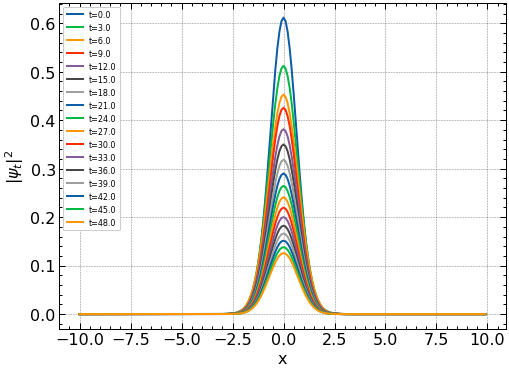

In [ ]:
for i in range(0,100,6):
    plt.plot(x,np.abs(res[i,:])**2, label=f't={dt*i}')
plt.legend(loc=2, prop={'size': 8})
plt.xlabel('x')
plt.ylabel('$|\psi_t|^2$');
plt.savefig(f'pic_QHD')

In [ ]:
plt.ioff()
files = list()
t_values = range(0,100,6)
for i in t_values:
    M = res[i,:]
    pic(M,f'{i+99}animation_QHD.png', i)
    files.append(f'{i+99}animation_QHD.png')

In [ ]:
images = list()
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'shr1D_QHD.gif', images, fps = 6);

In [ ]:
H,H_rhs = get_Hamiltonian(dt,dx,x,potential="DWP")
b = np.dot(H_rhs,initial_cond)
res = np.zeros((100,len(x)),dtype = complex)
res[0,:] = Thomas_method(H,b)

for i in range(1,100-1):
    res[i,:] = Thomas_method(H,res[i-1,:])

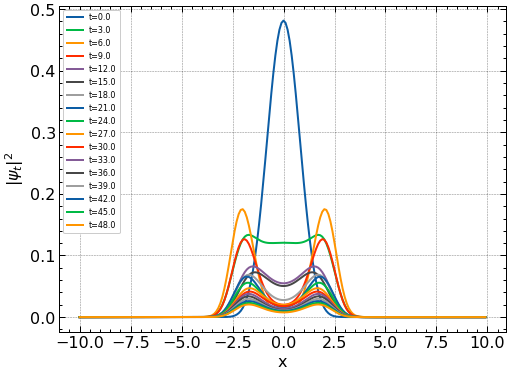

In [ ]:
for i in range(0,100,6):
    plt.plot(x,np.abs(res[i,:])**2, label=f't={dt*i}')
plt.legend(loc=2, prop={'size': 8})
plt.xlabel('x')
plt.ylabel('$|\psi_t|^2$');
plt.savefig(f'pic_DWP')

In [ ]:
plt.ioff()
files = list()
t_values = range(0,100,6)
for i in t_values:
    M = res[i,:]
    pic(M,f'{i+99}animation_DWP.png', i)
    files.append(f'{i+99}animation_DWP.png')

In [ ]:
images = list()
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'shr1D_DWP.gif', images, fps = 6);

Complexity

In [ ]:
dx_n = 0.01
x = np.arange(-10,10,dx_n)
len(x)

2000

In [ ]:
import time

In [ ]:
dx = np.arange(0.01, 0.1, 0.001)
len_x = []
times = []  
for dx_n in dx: 
    #initial states
    hdot = 1
    w = 1
    m = 1
    dt = 0.5
    x = np.arange(-10,10,dx_n) 

    start = time.time()
    H,H_rhs = get_Hamiltonian(dt,dx_n,x,potential="none")
    initial_cond = gaus(x,sigma=1)
    b = np.dot(H_rhs,initial_cond)
    res = np.zeros((100,len(x)),dtype = 'c8')
    res[0,:] = Thomas_method(H,b)

    for i in range(1,100-1):
        res[i,:] = Thomas_method(H,res[i-1,:])

    end = time.time() - start
    times.append(end)
    len_x.append(len(x))


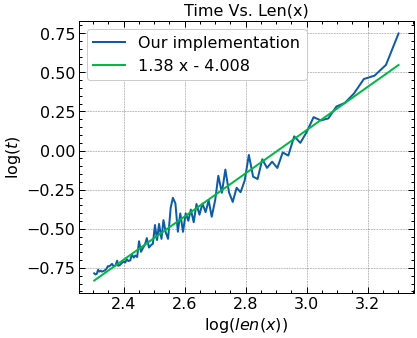

 
1.38 x - 4.008


In [ ]:
plt.figure(figsize=(6, 5))

plt.title('Time Vs. Len(x)')
plt.plot(np.log10(len_x), np.log10(times), label='Our implementation')
t = np.polyfit(np.log10(len_x), np.log10(times), 1)
f = np.poly1d(t)

x1 = np.log10(len_x)
plt.plot(x1, f(x1), label = '1.38 x - 4.008')


# plt.plot(len_x, n1_times, label='$O(n)$')
# plt.plot(len_x, n2_times, label='$O(n^2)$')
# plt.plot(len_x, n3_times, label=r'$O(n^3)$')
plt.xlabel('$\log(len(x))$')
plt.ylabel('$\log(t)$');


plt.legend()
plt.savefig('approximation1.png')

plt.show()
plt.close()
print(f)

## 2d Case

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def get_Hamiltonian2D(x, dt=1, dx=1, m=1, hdot=1, potential = 'none'):
    '''
    returns H - Hamiltonian for lhs and H_rhs - Hamiltonian for rhs parts of Crank-Nicolson method
    '''
    
    dj = 1+1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj = -1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H
    diagonal = np.ones(len(x), dtype=complex)*dj
    off_diagonal = np.ones(len(x)-1,dtype = complex)*oj
    
    H = sp.diags((off_diagonal,diagonal,off_diagonal),[-1,0,1]).toarray()
    
    dj_rhs = 1-1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H_rhs
    oj_rhs = 1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H_rhs
    diagonal_rhs = np.ones(len(x), dtype=complex)*dj
    off_diagonal_rhs = np.ones(len(x)-1,dtype = complex)*oj

    H_rhs = sp.diags((off_diagonal_rhs,diagonal_rhs,off_diagonal_rhs),[-1,0,1]).toarray()
    
    if potential == 'none':
        return np.kron(H,H), np.kron(H_rhs,H_rhs)

In [11]:
def gaus2d(x,y,sigma=1,mu=0,p0=0,h=1):
    '''
    initial conditions at t=0 as Gaussian wave packet
    '''
    psi = 1/(np.pi**(1/4)*np.sqrt(sigma))*np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2))*np.exp(1j*p0*x/h)
    return psi

In [ ]:
gaussa_2d = np.empty((len(x),len(x)))
for i, xi in enumerate(x):
    for j, xj in enumerate(x):
        gaussa_2d[i,j] = gaus2d(xi,xj)

In [ ]:
H2d,H2d_rhs = get_Hamiltonian2D(x)

In [ ]:
initial_cond2d=gaussa_2d.flatten()

b = np.dot(H2d_rhs,initial_cond2d)

In [ ]:
time = 250
res = np.zeros((time,len(x)**2),dtype = complex)
res[0,:] = sc.linalg.solve(H2d,b)

for i in range(1,time):
    res[i,:] = sc.linalg.solve(H2d,res[i-1,:])

In [ ]:
def pic(M,name):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(np.abs(M.reshape(len(x),len(x)))**2)
    plt.axis('off')
    fig.savefig(name)
    plt.close(fig);

In [ ]:
plt.ioff()
files = list()
for i in range(250):
    M = res[i,:]
    pic(M,f'{i+99}animation.png')
    files.append(f'{i+99}animation.png')

In [ ]:
images = list()
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'shr.gif', images, fps = 10);

## Speedup + TimeIt

Numba

In [ ]:
import numba
from numba import jit
from numba import njit
import time
import cupy as cp
import cProfile

In [12]:
@njit(debug=True)
def jit_Thomas_method(A, f):
    '''
    method solves the linear system with tridiagonal matrix of coefficients
    by using special approach of Gaussian elimination.
    Input: A - np.array() of size n-by-n - matrix of the linear system
           f - np.array() of size n-by-1 - vector of rhs
    Output: x - np.array() of size n-by-1 - solution of the system
    '''
    n = np.shape(A)[0]
    L = np.diag(np.ones(n,dtype= 'c8'))
    U = np.zeros((n,n),dtype= 'c8')
    y = np.zeros(n,dtype= 'c8')
    x = np.zeros(n,dtype= 'c8')
    
    U[0,0] = A[0,0]
    U[0,1] = A[0,1]
    y[0] = f[0]
    
    for i in range(1,n):
        beta_i = A[i,i-1]/U[i-1,i-1]
        alpha_i = A[i,i] - beta_i*A[i-1,i]
        L[i,i-1] = beta_i
        U[i,i] = alpha_i
        U[i-1,i] = A[i-1,i]
        y[i] = f[i]-beta_i*y[i-1]
    
    x[n-1] = y[n-1]/U[n-1,n-1]
    
    for i in range(n-2,-1,-1):
        x[i] = (y[i]-A[i,i+1]*x[i+1])/U[i,i]
    
    return x

@njit( debug=True)
def jit_get_Hamiltonian(dt, dx, x, m=1, hdot=1, potential = 'none'):
    '''
    returns H - Hamiltonian for lhs and H_rhs - Hamiltonian for rhs parts of Crank-Nicolson method
    '''
    
    dj = 1+1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj = -1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H
    diagonal = np.ones(len(x), dtype= 'c8')*dj
    off_diagonal = np.ones(len(x)-1,dtype = 'c8')*oj

    H = np.diag(diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)
    #H = sp.diags((off_diagonal,diagonal,off_diagonal),[-1,0,1]).toarray()
    
    dj_rhs = 1-1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj_rhs = 1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H_rhs
    diagonal_rhs = np.ones(len(x), dtype='c8')*dj
    off_diagonal_rhs = np.ones(len(x)-1,dtype = 'c8')*oj

    H_rhs = np.diag(diagonal_rhs) + np.diag(off_diagonal_rhs, 1) + np.diag(off_diagonal_rhs, -1)
    #H_rhs = sp.diags((off_diagonal_rhs,diagonal_rhs,off_diagonal_rhs),[-1,0,1]).toarray()
    
    if potential == 'none':
        return H, H_rhs

In [15]:
dx = np.arange(0.01, 0.2, 0.001)
len_x = []
times = []
times_jit = []   
for dx_n in dx: 
    #initial states
    hdot = 1
    w = 1
    m = 1
    dt = 0.5
    #dx = 0.1
    x = np.arange(-10,10,dx_n) 

    start = time.time()
    H,H_rhs = get_Hamiltonian(dt,dx_n,x,potential="none")
    initial_cond = gaus(x,sigma=1)
    b = np.dot(H_rhs,initial_cond)
    res = np.zeros((100,len(x)),dtype = 'c8')
    res[0,:] = Thomas_method(H,b)

    for i in range(1,100-1):
        res[i,:] = Thomas_method(H,res[i-1,:])

    end = time.time() - start


    start_jit = time.time()
    H,H_rhs = jit_get_Hamiltonian(dt,dx_n,x,potential="none")
    initial_cond = gaus(x,sigma=1)
    b = np.dot(H_rhs,initial_cond)
    res = np.zeros((100,len(x)),dtype = 'c8')
    res[0,:] = jit_Thomas_method(H,b)

    for i in range(1,100-1):
        res[i,:] = jit_Thomas_method(H,res[i-1,:])
    end_jit = time.time() - start_jit

    times.append(end)
    len_x.append(len(x))
    times_jit.append(end_jit)

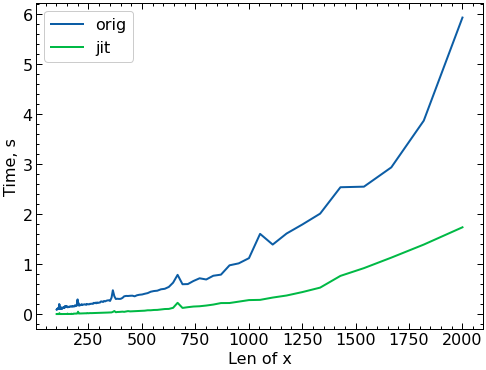

In [16]:
plt.plot(len_x, times, label='orig')
plt.plot(len_x, times_jit, label='jit')
plt.grid()
plt.legend()
plt.xlabel('Len of x')
plt.ylabel('Time, s')
plt.savefig('numpy vs jit')
plt.show()

Cuda

In [ ]:
import cupy as cp

In [ ]:
# import cupy as cp

In [17]:
def cp_get_Hamiltonian2D(x, dt=1, dx=1, m=1, hdot=1, potential = 'none'):
    '''
    returns H - Hamiltonian for lhs and H_rhs - Hamiltonian for rhs parts of Crank-Nicolson method
    '''
    
    dj = 1+1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H
    oj = -1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H
    diagonal = cp.ones(len(x), dtype=complex)*dj
    off_diagonal = cp.ones(len(x)-1,dtype = complex)*oj
    
    #H = sp.diags((off_diagonal,diagonal,off_diagonal),[-1,0,1]).toarray()
    H = cp.diag(diagonal) + cp.diag(off_diagonal, 1) + cp.diag(off_diagonal, -1)
    
    dj_rhs = 1-1j*dt*hdot/(2*m*dx**2) #elenemts on the main diagonal of H_rhs
    oj_rhs = 1j*dt*hdot/(4*m*dx**2) #elements on the upper and lower diagonal of H_rhs
    diagonal_rhs = cp.ones(len(x), dtype=complex)*dj
    off_diagonal_rhs = cp.ones(len(x)-1,dtype = complex)*oj

    H_rhs = cp.diag(diagonal_rhs) + cp.diag(off_diagonal_rhs, 1) + cp.diag(off_diagonal_rhs, -1)
    #H_rhs = sp.diags((off_diagonal_rhs,diagonal_rhs,off_diagonal_rhs),[-1,0,1]).toarray()
    
    if potential == 'none':
        return cp.kron(H,H), cp.kron(H_rhs,H_rhs)

In [18]:
def cp_gaus2d(x,y,sigma=1,mu=0,p0=0,h=1):
    '''
    initial conditions at t=0 as Gaussian wave packet
    '''
    psi = 1/(np.pi**(1/4)*np.sqrt(sigma))*np.exp(-((x-mu)**2 + (y-mu)**2)/(2*sigma**2))*np.exp(1j*p0*x/h)
    return psi

In [19]:
# dx = 1
# x = cp.arange(-10,10,dx)
# gaussa_2d = cp.empty((len(x),len(x)))
# for i, xi in enumerate(x):
#     for j, xj in enumerate(x):
#         gaussa_2d[i,j] = cp_gaus2d(xi,xj)

In [ ]:
import time

In [ ]:
dx1 = np.arange(0.2, 3, 0.1)
times_cp = []
times_np = []

for dx_n in dx1:
  ### cupy
  x = cp.arange(-10,10,dx_n)

  start = time.time()

  gaussa_2d = cp.empty((len(x),len(x)))
  for i, xi in enumerate(x):
      for j, xj in enumerate(x):
          gaussa_2d[i,j] = cp_gaus2d(xi,xj)

  H2d,H2d_rhs = cp_get_Hamiltonian2D(x)

  initial_cond2d= gaussa_2d.flatten()

  b = cp.dot(H2d_rhs,initial_cond2d)

  time_int = 250
  res = cp.zeros((time_int,len(x)**2),dtype = complex)
  res[0,:] = cp.linalg.solve(H2d,b)

  for i in range(1,time_int):
    res[i,:] = cp.linalg.solve(H2d,res[i-1,:])

  end_cp = time.time() - start
  times_cp.append(end_cp)



  ### numpy
  x = np.arange(-10,10,dx_n)

  start = time.time()

  gaussa_2d = np.empty((len(x),len(x)))
  for i, xi in enumerate(x):
      for j, xj in enumerate(x):
          gaussa_2d[i,j] = gaus2d(xi,xj)

  H2d,H2d_rhs = get_Hamiltonian2D(x)

  initial_cond2d=gaussa_2d.flatten()

  b = np.dot(H2d_rhs,initial_cond2d)

  time_int = 250
  res = np.zeros((time_int,len(x)**2),dtype = complex)
  res[0,:] = np.linalg.solve(H2d,b)

  for i in range(1,time_int):
    res[i,:] = np.linalg.solve(H2d,res[i-1,:])

  end_np = time.time() - start
  times_np.append(end_np)

<ipython-input-7-38e05144f1f4>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussa_2d[i,j] = cp_gaus2d(xi,xj)
<ipython-input-7-38e05144f1f4>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussa_2d[i,j] = gaus2d(xi,xj)


In [ ]:
plt.plot(dx1, times_np, label='orig')
plt.plot(dx1, times_cp, label='cuda')
plt.grid()
plt.legend()
plt.xlabel(f'$\delta x$')
plt.ylabel('Time, s')
plt.savefig('numpy vs cuda')
plt.show()

In [21]:
dx1 = np.arange(0.4, 2, 0.3)
times_cp = []
times_np = []

for dx_n in dx1:
  ### cupy
  x = cp.arange(-10,10,dx_n)

  start = time.time()

  gaussa_2d = cp.empty((len(x),len(x)))
  for i, xi in enumerate(x):
      for j, xj in enumerate(x):
          gaussa_2d[i,j] = cp_gaus2d(xi,xj)

  H2d,H2d_rhs = cp_get_Hamiltonian2D(x)

  initial_cond2d= gaussa_2d.flatten()

  b = cp.dot(H2d_rhs,initial_cond2d)

  time_int = 250
  res = cp.zeros((time_int,len(x)**2),dtype = complex)
  res[0,:] = cp.linalg.solve(H2d,b)

  for i in range(1,time_int):
    res[i,:] = cp.linalg.solve(H2d,res[i-1,:])

  end_cp = time.time() - start
  times_cp.append(end_cp)



  ### numpy
  x = np.arange(-10,10,dx_n)

  start = time.time()

  gaussa_2d = np.empty((len(x),len(x)))
  for i, xi in enumerate(x):
      for j, xj in enumerate(x):
          gaussa_2d[i,j] = gaus2d(xi,xj)

  H2d,H2d_rhs = get_Hamiltonian2D(x)

  initial_cond2d=gaussa_2d.flatten()

  b = np.dot(H2d_rhs,initial_cond2d)

  time_int = 250
  res = np.zeros((time_int,len(x)**2),dtype = complex)
  res[0,:] = np.linalg.solve(H2d,b)

  for i in range(1,time_int):
    res[i,:] = np.linalg.solve(H2d,res[i-1,:])

  end_np = time.time() - start
  times_np.append(end_np)

<ipython-input-21-8e03119de285>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussa_2d[i,j] = cp_gaus2d(xi,xj)
<ipython-input-21-8e03119de285>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussa_2d[i,j] = gaus2d(xi,xj)


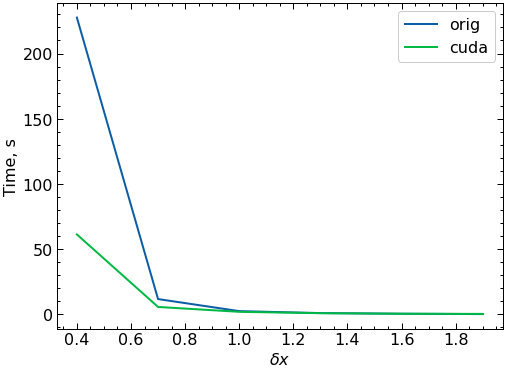

In [23]:
plt.plot(dx1, times_np, label='orig')
plt.plot(dx1, times_cp, label='cuda')
plt.grid()
plt.legend()
plt.xlabel(f'$\delta x$')
plt.ylabel('Time, s')
plt.savefig('numpy vs cuda lower grid')
plt.show()